In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# все любят картиночки:)

In [2]:
# docker контейнер уже должен содержать в себе скачанные данные
# скачаны отсюда: https://grouplens.org/datasets/movielens/
DATA_DIR = "/data/ml-latest"

In [3]:
# смотрим, какие файлы у нас есть
!ls {DATA_DIR}

README.txt	   genome-tags.csv  movies.csv	 tags.csv
genome-scores.csv  links.csv	    ratings.csv


In [4]:
# обратим внимание на файл с оценками
!head {DATA_DIR}/ratings.csv

In [5]:
# для подготовки данных будем использвоать Apache Spark
# (популярный фреймворк распределённых вычислений)
from pyspark.sql import SparkSession

spark = (
    SparkSession
    .builder
    # если виртуальной машине нельзя добавить памяти, можно использовать меньше
    .config("spark.driver.memory", "4g")
    # можно явно количество ядер, которые будет использовать Spark
    # либо поставить звёздочку для всех доступных виртуальной машине
    .master("local[*]")
    .getOrCreate()
)

In [6]:
# считываем данные из CSV
# и преобразуем время проставления оценки из целого числа в дату со временем
import os
import pyspark.sql.functions as sql_func

ratings = (
    spark
    .read
    .csv(
        os.path.join(DATA_DIR, "ratings.csv"),
        header=True,
        inferSchema=True
    )
    # если используется меньше памяти,
    # то здесь можно взять не все данные, а а небольшую выборку
    # даже при fraction=0.01 качественная картина не меняется
    .sample(withReplacement=False, fraction=1.0, seed=0)
    .withColumn("rating_datetime", sql_func.from_unixtime("timestamp"))
    .drop("timestamp")
    .cache()
)

In [7]:
# оцениваем размеры данных
print("всего пользователей:", ratings.select("userId").distinct().count())
print("всего фильмов:", ratings.select("movieId").distinct().count())
print("всего оценок:", ratings.count())

всего пользователей: 270896
всего фильмов: 45115
всего оценок: 26024289


In [8]:
# достаточно хорошим baseline является предсказывать среднюю оценку
mean_rating = ratings.agg(sql_func.avg("rating")).first()[0]
print("средняя оценка:", mean_rating)

средняя оценка: 3.5280903543608817


In [9]:
# функция, с помощью которой мы будем вычислять RMSE на обучающей выборке
from pyspark.sql import DataFrame
import numpy as np

def simple_evaluate(predictions_df: DataFrame) -> float:
    return np.sqrt(
            ratings
            .join(
                predictions_df,
                ["movieId", "userId"]
            ).select(
                sql_func.pow(
                    ratings.rating - predictions_df.prediction,
                    2
                ).alias("squared_error")
            )
            .agg(sql_func.avg("squared_error"))
            .first()[0]
    )

In [10]:
# рекомендуем любому пользователю любой фильм случайно
mean_predictions = ratings.withColumn("prediction", sql_func.lit(mean_rating))
print("ошибка предсказания:", simple_evaluate(mean_predictions))

ошибка предсказания: 1.0654427431969717


In [11]:
# посмотрим на распределение средних оценок разных фильмов
movie_ratings = (
    ratings
    .groupBy("movieId")
    .agg(sql_func.avg("rating").alias("avg_movie_rating"))
    .cache()
)

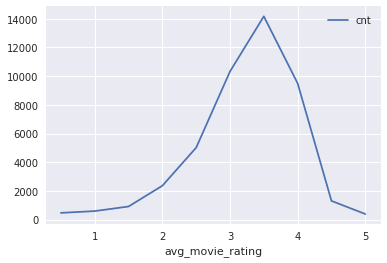

In [12]:
# фильмы бывают более и менее популярные - выбросы есть в обе стороны,
# но "средних" фильмов всё-таки большинство
histogram = (
        movie_ratings
        .select((0.5 * sql_func.ceil(2 * sql_func.col("avg_movie_rating")))
                .alias("avg_movie_rating"))
        .groupBy("avg_movie_rating")
        .agg(sql_func.count("avg_movie_rating").alias("cnt"))
        .orderBy("avg_movie_rating")
        .toPandas()
)
sns.set()
histogram.plot(x="avg_movie_rating", y="cnt")
plt.show()

In [13]:
# рекомендуем наиболее популярные фильмы
avg_movie_rating_predictions = (
    ratings
    .join(movie_ratings, "movieId")
    .select(
        ratings.movieId,
        ratings.userId,
        ratings.rating,
        movie_ratings.avg_movie_rating.alias("prediction")
    )
)
print("ошибка предсказания:", simple_evaluate(avg_movie_rating_predictions))

ошибка предсказания: 0.9609075716068508


In [14]:
# у разных пользователей разные распределения оценок
# кто-то более придирчив, а кто-то всем ставит пятёрки
user_ratings = (
    ratings
    .groupBy("userId")
    .agg(sql_func.avg("rating").alias("avg_user_rating"))
    .cache()
)

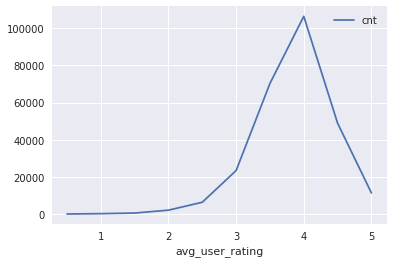

In [15]:
# в среднем, людям свойственно благосклонно относиться к предметам, которые они часто потребляют
histogram = (
        user_ratings
        .select((0.5 * sql_func.ceil(2 * sql_func.col("avg_user_rating")))
                .alias("avg_user_rating"))
        .groupBy("avg_user_rating")
        .agg(sql_func.count("avg_user_rating").alias("cnt"))
        .orderBy("avg_user_rating")
        .toPandas()
)
histogram.plot(x="avg_user_rating", y="cnt")
plt.show()

In [16]:
# мы можем предсказывать оценку для пары (пользователь, фильм)
# как полусумму от средней оценки фильма и средней оценки, которую ставит пользователь
two_means_predictions = (
    ratings
    .join(movie_ratings, "movieId")
    .join(user_ratings, "userId")
    .select(
        ratings.movieId,
        ratings.userId,
        ratings.rating,
        (0.5 * (movie_ratings.avg_movie_rating +
                user_ratings.avg_user_rating)).alias("prediction")
    )
)
print("ошибка предсказания:", simple_evaluate(two_means_predictions))

ошибка предсказания: 0.9081958453358785


In [17]:
# а можем и не полусумму, а подобрать коэффициенты
# с помощью линейной регрессии
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

train = (
    VectorAssembler(
        inputCols = ["avg_movie_rating", "avg_user_rating"],
        outputCol = "features"
    ).transform(
        ratings
        .join(movie_ratings, "movieId")
        .join(user_ratings, "userId")
    )
    .withColumnRenamed("rating", "label")
    .select("movieId", "userId", "label", "features")
    .cache()
)
linear_model = LinearRegression().fit(train)
stacked_prediction = (
    ratings
    .join(linear_model.transform(train), ["movieId", "userId"])
    .select("movieId", "userId", "prediction")
)
print("ошибка предсказания:", simple_evaluate(stacked_prediction))

ошибка предсказания: 0.871930725020582


In [18]:
# получаем некоторую формулу для предсказания оценки, которую можно использовать для рекомендаций
print(
    "[на сколько пользователь оценит фильм] = {} + {} * [средняя оценка этого фильма] + {} * [средняя оценка из поставленных этим пользователем]"
    .format(
        round(linear_model.intercept, 2),
        round(linear_model.coefficients[0], 2),
        round(linear_model.coefficients[1], 2)
    )
)

[на сколько пользователь оценит фильм] = -2.5 + 0.85 * [средняя оценка этого фильма] + 0.86 * [средняя оценка из поставленных этим пользователем]


Эта формула является частным случаем рекомендтельной архитектуры, когда мы для заданного пользователя $u$ получаем рекомендации в два этапа:

1. составляем список объектов $i$, которые в принципе могут заинтересовать пользователя $u$
1. ранжируем этот список объектов по некоторому правилу

В частности, правило может основываться на присвоении каждому объекту из списка некоторой релевантности как функции от свойств пользователя и самого объекта: $r\left(u,i\right)$

В простейшем примере, рассмотренном в этой тетради $r\left(u,i\right)=ar_i+br_u+c$ - линейная функция от двух переменных:

1. $r_i$ - одного свойства объекта (популярности фильма в виде средней оценки) и
1. $r_u$ - одного свойства пользователя ("разборчивости" в виде среднего от распределения всех оценок в истории этого пользователя)